<font size="6"><i>This code illustrates the usage of <b>XGBoost</b> to build a collection of boosted trees and use them on the [IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) Telco Churn dataset to predict if a customer will stop using a company's service, i.e. <b>customer will churn</b>.</i></font>

<hr>

In [1]:
# Importing necessary modules

import pandas as pd
import numpy as np
import xgboost as xgb # XGBoost model
from sklearn.model_selection import train_test_split # splitting data into training and testing
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, average_precision_score # for scoring & evaluating models
from sklearn.metrics import confusion_matrix # for accuracy, recall, precision; creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import Image, display

%matplotlib inline


# Setting display options

pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 800)

In [2]:
# Import the data

df = pd.read_excel('https://github.com//ankursikka//Impact-DS//raw/main/Churn-Prediction-Classification/XGBoost/Telco_customer_churn.xlsx',sheet_name='Telco_Churn')

In [3]:
# Let us look at the top rows

df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


<i><b>We need to drop variables which will skew the training data. The last 4 columns contain the information that should not be used for training as we are actually trying to predict the churn itself.</b> </i>

In [4]:
# Dropping the variables

df2=df.drop(['Churn Label', 'CLTV' ,'Churn Score','Churn Reason'], axis=1)
df2.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [5]:
# Exploratory data analysis & Feature evaluation

print(df2.nunique(axis=0).sort_values().to_string())

Count                   1
Country                 1
State                   1
Phone Service           2
Paperless Billing       2
Dependents              2
Partner                 2
Senior Citizen          2
Gender                  2
Churn Value             2
Device Protection       3
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Payment Method          4
Tenure Months          73
City                 1129
Monthly Charges      1585
Longitude            1651
Latitude             1652
Zip Code             1652
Lat Long             1652
Total Charges        6531
CustomerID           7043


<b><i>Count, Country & State have only 1 value and thus they are not a relevant feature for classification. These will be dropped from data.

Additionally, we don't need customer ID since it is unique to a customer, alphanumeric and does not hold any relevance for model training.

The Lat Long column holds the same information present in Lat and Long column and thus provides redundant information.</i></b>

In [6]:
# Dropping irrelevant features (feature reduction)

try:
    df2.drop(['Count','Country','State','CustomerID','Lat Long'], axis=1, inplace=True)
except BaseException as e:
    if type(e)==KeyError:
        print('Columns already dropped')


In [7]:
# Adjusting column names - replacing spaces with underscore

df2.columns = df2.columns.str.replace(' ','_')

<hr>

<font size=6><i><b>Part 1: Data Preparation; Handling missing data</b><i></font>

In [8]:
# Identifying missing data - XGB can handle missing data and we need to set it to 0
# Checking each column to ensure that the data in the feature is as expected

citydict = dict()

from geopy.geocoders import Nominatim

def is_valid_city(city_name):
    geolocator = Nominatim(user_agent='citycheck')

    # Geocode the city name
    location = geolocator.geocode(city_name + ', United States')

    # Check if a location is found
    if location is not None:
        return True
    else:
        return False
      

for city in df2.City.unique():
    citydict[city]=is_valid_city(city)

cityls = []

for k, v in citydict.items():
    if v==False:
        cityls.append(k) 

if len(cityls)==0:
    print('All cities are valid')
else:
    print(cityls)

All cities are valid


In [9]:
# Checking fields with <10 unique values

x = [col for col in df2.columns if df2[col].nunique()<10]
df2[x].apply(lambda x:x.unique(),axis=0)

Gender                                                                                     [Male, Female]
Senior_Citizen                                                                                  [No, Yes]
Partner                                                                                         [No, Yes]
Dependents                                                                                      [No, Yes]
Phone_Service                                                                                   [Yes, No]
Multiple_Lines                                                                [No, Yes, No phone service]
Internet_Service                                                                   [DSL, Fiber optic, No]
Online_Security                                                            [Yes, No, No internet service]
Online_Backup                                                              [Yes, No, No internet service]
Device_Protection                             

In [10]:
z = [col for col in df2.columns if df2[col].nunique()>=10]
z

['City',
 'Zip_Code',
 'Latitude',
 'Longitude',
 'Tenure_Months',
 'Monthly_Charges',
 'Total_Charges']

In [11]:
# Checking months of tenure

df2.Tenure_Months.unique()

array([ 2,  8, 28, 49, 10,  1, 47, 17,  5, 34, 11, 15, 18,  9,  7, 12, 25,
       68, 55, 37,  3, 27, 20,  4, 58, 53, 13,  6, 19, 59, 16, 52, 24, 32,
       38, 54, 43, 63, 21, 69, 22, 61, 60, 48, 40, 23, 39, 35, 56, 65, 33,
       30, 45, 46, 62, 70, 50, 44, 71, 26, 14, 41, 66, 64, 29, 42, 67, 51,
       31, 57, 36, 72,  0], dtype=int64)

In [12]:
# Checking zip code, latitude and longitude consistency

import re

def validate_zip_code(zip_code):
    pattern = r'^\d{5}$'
    return bool(re.match(pattern, str(zip_code)))

def validate_latitude(latitude):
    return -90 <= latitude <= 90

def validate_longitude(longitude):
    return -180 <= longitude <= 180

zipdc = {}
latdc = {}
longdc = {}

for zip in df2.Zip_Code.unique():
    zipdc[str(zip)]=validate_zip_code(zip)

for lat in df2.Latitude.unique():
    latdc[str(lat)]=validate_latitude(lat)

for lon in df2.Longitude.unique():
    longdc[str(lon)]=validate_longitude(lon)


def checkziplatlong(x):
    ls=[]

    for k, v in x.items():
        if v==False:
            ls.append(k) 

    if len(ls)==0:
        return('All values are valid!')
    else:
        return(f"Erroneous values: {ls}")

print(f"Zip Check: {checkziplatlong(zipdc)}")
print(f"Latitude Check: {checkziplatlong(latdc)}")
print(f"Longitude Check: {checkziplatlong(longdc)}")



Zip Check: All values are valid!
Latitude Check: All values are valid!
Longitude Check: All values are valid!


In [13]:
# Checking monthly charges

def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

if len(df2[df2.Monthly_Charges.apply(isfloat)==False].index)==0:
    print('All values for Monthly_Charges are valid!\n')
else:
    print('Fix these rows for Monthly_Charges:\n', df2[df2.Monthly_Charges.apply(isfloat)==False],'\n')


if len(df2[df2.Total_Charges.apply(isfloat)==False].index)==0:
    print('All values for Total_Charges are valid!')
else:
    print('Fix these rows for Total_Charges:\n', df2[df2.Total_Charges.apply(isfloat)==False])

All values for Monthly_Charges are valid!

Fix these rows for Total_Charges:
                 City  Zip_Code   Latitude   Longitude  Gender Senior_Citizen Partner Dependents  Tenure_Months Phone_Service    Multiple_Lines Internet_Service      Online_Security        Online_Backup    Device_Protection         Tech_Support         Streaming_TV     Streaming_Movies  Contract Paperless_Billing             Payment_Method  Monthly_Charges Total_Charges  Churn_Value
2234  San Bernardino     92408  34.084909 -117.258107  Female             No     Yes         No              0            No  No phone service              DSL                  Yes                   No                  Yes                  Yes                  Yes                   No  Two year               Yes  Bank transfer (automatic)            52.55                          0
2438    Independence     93526  36.869584 -118.189241    Male             No      No         No              0           Yes                No          

<b><i>We observe that there are 11 records where Total_Charges do not include a valid value. 

We have several ways to treat this but since all of these have Tenure_Months = 0 it is likely that they have not been charged since  they are new customers. 

In this particular situation the best option is to set the Total_Charges for these records to 0. </i></b>

In [14]:
# Replacing nulls with 0 for Total Charges

df2.loc[(df2.Total_Charges.apply(isfloat)==False),['Total_Charges']]=0

In [15]:
# Changing data type from object to float

df2[['Monthly_Charges','Total_Charges']]=df2[['Monthly_Charges','Total_Charges']].apply(pd.to_numeric)

<hr>

<font size=6><i><b>Part 2: Splitting target and predictor variables; conversion from categorical to continuous for XGBoost</b><i></font>

In [16]:
Independent = df2.drop(['Churn_Value'], axis=1).copy() # Removing the target/ dependent variable as this is what we want to predict; also creating a copy
Dependent = df2['Churn_Value'].copy() # Copying the dependent variable to be predicted

In [17]:
# Creating a list for encoding

encols = [x for x in df2.columns if df2[x].dtype==object]
encols

['City',
 'Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method']

In [18]:
# Changing categorical data to continuous by doing One-Hot encoding

Independent_encoded = pd.get_dummies(Independent,columns=encols)

Independent_encoded.columns = Independent_encoded.columns.str.replace(' ','_')

Independent_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,City_Aptos,City_Arbuckle,City_Arcadia,City_Arcata,City_Armona,City_Arnold,City_Aromas,City_Arroyo_Grande,City_Artesia,City_Arvin,City_Atascadero,City_Atherton,City_Atwater,City_Auberry,City_Auburn,City_Avalon,City_Avenal,City_Avery,City_Avila_Beach,City_Azusa,City_Badger,City_Baker,City_Bakersfield,City_Baldwin_Park,City_Ballico,City_Bangor,City_Banning,City_Barstow,City_Bass_Lake,City_Bayside,City_Beale_Afb,City_Beaumont,City_Bell,City_Bella_Vista,City_Bellflower,City_Belmont,City_Belvedere_Tiburon,City_Ben_Lomond,City_Benicia,City_Benton,City_Berkeley,City_Berry_Creek,City_Bethel_Island,City_Beverly_Hills,City_Bieber,City_Big_Bar,City_Big_Bear_City,City_Big_Bear_Lake,City_Big_Bend,City_Big_Creek,City_Big_Oak_Flat,City_Big_Pine,City_Big_Sur,City_Biggs,City_Biola,City_Birds_Landing,City_Bishop,City_Blairsden_Graeagle,City_Blocksburg,City_Bloomington,City_Blue_Lake,City_Blythe,City_Bodega,City_Bodega_Bay,City_Bodfish,City_Bolinas,City_Bonita,City_Bonsall,City_Boonville,City_Boron,City_Borrego_Springs,City_Boulder_Creek,City_Boulevard,City_Bradley,City_Branscomb,City_Brawley,City_Brea,City_Brentwood,City_Bridgeport,City_Bridgeville,City_Brisbane,City_Brookdale,City_Brooks,City_Browns_Valley,City_Brownsville,City_Buellton,City_Buena_Park,City_Burbank,City_Burlingame,City_Burney,City_Burnt_Ranch,City_Burson,City_Butte_City,City_Buttonwillow,City_Byron,City_Cabazon,City_Calabasas,City_Calexico,City_Caliente,City_California_City,City_California_Hot_Springs,City_Calimesa,City_Calipatria,City_Calistoga,City_Callahan,City_Calpine,City_Camarillo,City_Cambria,City_Camino,City_Camp_Nelson,City_Campbell,City_Campo,City_Campo_Seco,City_Camptonville,City_Canby,City_Canoga_Park,City_Cantua_Creek,City_Canyon_Country,City_Canyon_Dam,City_Capay,City_Capistrano_Beach,City_Capitola,City_Cardiff_By_The_Sea,City_Carlotta,City_Carlsbad,City_Carmel,City_Carmel_By_The_Sea,City_Carmel_Valley,City_Carmichael,City_Carnelian_Bay,City_Carpinteria,City_Carson,City_Caruthers,City_Casmalia,City_Caspar,City_Cassel,City_Castaic,City_Castella,City_Castro_Valley,City_Castroville,City_Cathedral_City,City_Catheys_Valley,City_Cayucos,City_Cazadero,City_Cedar_Glen,City_Cedarville,City_Ceres,City_Cerritos,City_Challenge,City_Chatsworth,City_Chester,City_Chico,City_Chilcoot,City_Chino,City_Chino_Hills,City_Chowchilla,City_Chualar,City_Chula_Vista,City_Citrus_Heights,City_Claremont,City_Clarksburg,City_Clayton,City_Clearlake,City_Clearlake_Oaks,City_Clements,City_Clio,City_Clipper_Mills,City_Cloverdale,City_Clovis,City_Coachella,City_Coalinga,City_Coarsegold,City_Cobb,City_Coleville,City_Colfax,City_Colton,City_Columbia,City_Colusa,City_Comptche,City_Compton,City_Concord,City_Cool,City_Copperopolis,City_Corcoran,City_Corning,City_Corona,City_Corona_Del_Mar,City_Coronado,City_Corte_Madera,City_Costa_Mesa,City_Cotati,City_Cottonwood,City_Coulterville,City_Courtland,City_Covelo,City_Covina,City_Crescent_City,City_Crescent_Mills,City_Cressey,City_Crestline,City_Creston,City_Crockett,City_Crows_Landing,City_Culver_City,City_Cupertino,City_Cutler,City_Cypress,City_Daggett,City_Daly_City,City_Dana_Point,City_Danville,City_Darwin,City_Davenport,City_Davis,City_Davis_Creek,City_Death_Valley,City_Deer_Park,City_Del_Mar,City_Del_Rey,City_Delano,City_Delhi,City_Denair,City_Descanso,City_Desert_Center,City_Desert_Hot_Springs,City_Diamond_Bar,City_Diamond_Springs,City_Dillon_Beach,City_Dinuba,City_Dixon,City_Dobbins,City_Dorris,City_Dos_Palos,City_Dos_Rios,Ci

In [19]:
# Ensuring dependent variable has correct values

Dependent.unique()

array([1, 0], dtype=int64)

<hr>

<font size=6><i><b>Part 3:Building the initial XGBoost model</b></i></font>

In [20]:
# Checking % of people who churned

sum(Dependent)/len(Dependent.index)

0.2653698707936959

In [21]:
# Splitting data into training and testing, while ensuring the balance is kept with the original data

X_Train, X_Test, y_Train, y_Test = train_test_split(Independent_encoded, Dependent, stratify=Dependent, random_state=42) # using stratify parameter to ensure balancing
print(sum(y_Train)/len(y_Train))
print(sum(y_Test)/len(y_Test))

0.2654297614539947
0.26519023282226006


In [22]:
model = xgb.XGBClassifier(objective='binary:logistic', missing=0, seed=42,  early_stopping_rounds=10, eval_metric='aucpr') 

# early_stopping_rounds stops the model training if it does not improve. The total number of rounds is the added rounds after 
# the last round where the validation criteria (AUC-PR) does not improve

model.fit(X_Train, y_Train, verbose=True, eval_set=[(X_Test, y_Test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64414
[2]	validation_0-aucpr:0.65129
[3]	validation_0-aucpr:0.65054
[4]	validation_0-aucpr:0.65323
[5]	validation_0-aucpr:0.64855
[6]	validation_0-aucpr:0.65460
[7]	validation_0-aucpr:0.65896
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65851
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66528
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66001
[15]	validation_0-aucpr:0.66028
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65590
[18]	validation_0-aucpr:0.65735
[19]	validation_0-aucpr:0.65857
[20]	validation_0-aucpr:0.65896


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
print(model.base_score)

None


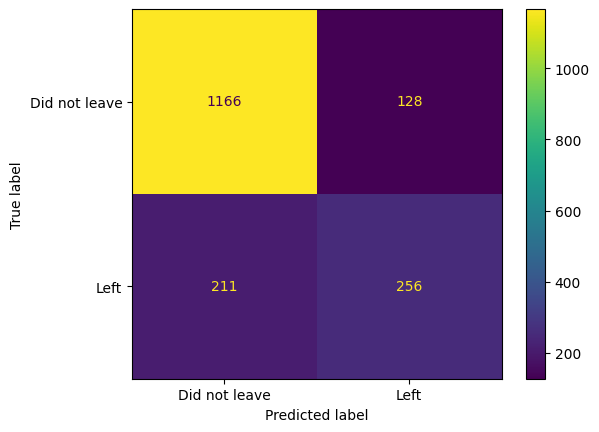

In [24]:
# Plotting the confusion matrix

ConfusionMatrixDisplay.from_estimator(model, X_Test, y_Test, values_format='d', display_labels=['Did not leave','Left'])

plt.show()

<b><i>From the confusion metrics we can see that the number of people who churned ('Left') are not accurately captured by the model (~55% recall). Thus, we need to optimize by tuning hyperparameters.

Since it is also an imbalanced problem as the number of people churning is much more than the number of people who don't, and we are interested in finding the prediction for people who leave (positive class), we use PR AUC (vs ROC AUC) as validation criteria. This means we have to also adjust parameters related to weight imbalance, which is scale_pos_weight.<b></i>

<hr>

<font size=6><b><i>Part 4: Optimizing parameters using cross valiation and grid search</i></b></font>

<b><i>Since XGB has a lot of hyperparameters, tuning these manually is not recommended. Instead we will be making use of GridSearchCV() by passing several likely parameters at once</b></i>

In [25]:
# Defining the hyperparameter grid for grid search

param_grid = {
    'max_depth': [3, 5, 7], # Tree depth
    'learning_rate': [0.1, 0.5, 1], # Learning rate
    'n_estimators': [100, 200, 300], # Rounds of boosting (trees)
    'gamma': [0, 0.25, 1.0], # Parameter for pruning
    'reg_lambda': [0, 1.0, 10.0], # Penalty parameter for regularization; avoids overfitting
    'scale_pos_weight': [1, 3, 5] # Weights for positive class; used to control imbalance

}

In [26]:
# Definiing the scoring parameter as AUC-PR

# scoring=make_scorer(average_precision_score)
scoring=make_scorer(roc_auc_score)

In [27]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', # Loss function to be optimized during training
                                                       missing=0, # Missing data is represented by 0
                                                       seed=42,  # Random seed for reproducibility
                                                       early_stopping_rounds=10, 
                                                       eval_metric='auc',
                                                       subsample=0.9, # Sampling rows to speed up grid search and cross-validation
                                                       colsample_bytree=0.5),  # Sampling columns to avoid overfitting
                                                       n_jobs=6, # Parallel jobs on CPU
                                                       param_grid=param_grid, 
                                                       cv=5,
                                                    #    verbose=True,
                                                       scoring=scoring)


grid_search.fit(X_Train, y_Train, verbose=True, eval_set=[(X_Test, y_Test)])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

[0]	validation_0-auc:0.82576
[1]	validation_0-auc:0.83702
[2]	validation_0-auc:0.84815
[3]	validation_0-auc:0.84821
[4]	validation_0-auc:0.85174
[5]	validation_0-auc:0.85322
[6]	validation_0-auc:0.85230
[7]	validation_0-auc:0.85416
[8]	validation_0-auc:0.85601
[9]	validation_0-auc:0.85590
[10]	validation_0-auc:0.85737
[11]	validation_0-auc:0.85856
[12]	validation_0-auc:0.85928
[13]	validation_0-auc:0.85913
[14]	validation_0-auc:0.85938
[15]	validation_0-auc:0.85936
[16]	validation_0-auc:0.85947
[17]	validation_0-auc:0.85957
[18]	validation_0-auc:0.85935
[19]	validation_0-auc:0.85933
[20]	validation_0-auc:0.85941
[21]	validation_0-auc:0.85920
[22]	validation_0-auc:0.85939
[23]	validation_0-auc:0.85955
[24]	validation_0-auc:0.86032
[25]	validation_0-auc:0.86062
[26]	validation_0-auc:0.86032
[27]	validation_0-auc:0.86044
[28]	validation_0-auc:0.86070
[29]	validation_0-auc:0.86141
[30]	validation_0-auc:0.86135
[31]	validation_0-auc:0.86113
[32]	validation_0-auc:0.86150
[33]	validation_0-au

In [28]:
print(best_params)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [29]:
# Training the final optimized model with best parameters

optimized_xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                                        gamma=0.25, 
                                        learning_rate=0.1, 
                                        max_depth=5, 
                                        n_estimators=100, 
                                        reg_lambda=10, 
                                        scale_pos_weight=3,
                                        missing=0, 
                                        seed=42,  
                                        early_stopping_rounds=10, 
                                        eval_metric='aucpr',
                                        subsample=0.9,
                                        colsample_bytree=0.5
                                        )
                                           
optimized_xgb_model.fit(X_Train,
                         y_Train, 
                         verbose=True, 
                         eval_set=[(X_Test, y_Test)])

[0]	validation_0-aucpr:0.59388
[1]	validation_0-aucpr:0.60217
[2]	validation_0-aucpr:0.62223
[3]	validation_0-aucpr:0.62592
[4]	validation_0-aucpr:0.62817
[5]	validation_0-aucpr:0.62889
[6]	validation_0-aucpr:0.62865
[7]	validation_0-aucpr:0.62835
[8]	validation_0-aucpr:0.63251
[9]	validation_0-aucpr:0.63544
[10]	validation_0-aucpr:0.63937
[11]	validation_0-aucpr:0.64990
[12]	validation_0-aucpr:0.64841
[13]	validation_0-aucpr:0.64659
[14]	validation_0-aucpr:0.64631
[15]	validation_0-aucpr:0.64580
[16]	validation_0-aucpr:0.64030
[17]	validation_0-aucpr:0.64033
[18]	validation_0-aucpr:0.63951
[19]	validation_0-aucpr:0.64429
[20]	validation_0-aucpr:0.64763
[21]	validation_0-aucpr:0.65039
[22]	validation_0-aucpr:0.65067
[23]	validation_0-aucpr:0.64720
[24]	validation_0-aucpr:0.65217
[25]	validation_0-aucpr:0.65402
[26]	validation_0-aucpr:0.65285
[27]	validation_0-aucpr:0.65439
[28]	validation_0-aucpr:0.65586
[29]	validation_0-aucpr:0.65702
[30]	validation_0-aucpr:0.65632
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

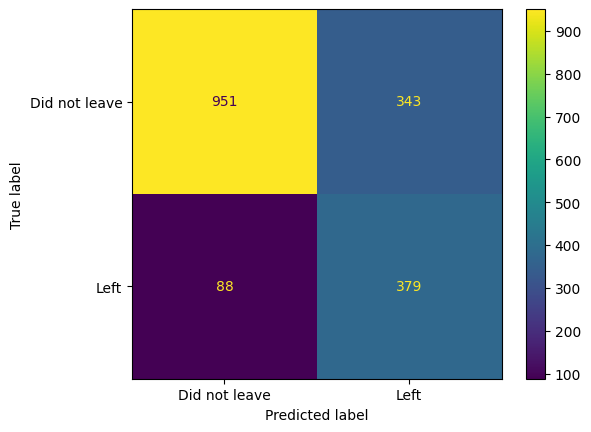

In [30]:
# Plotting the confusion matrix

ConfusionMatrixDisplay.from_estimator(optimized_xgb_model, X_Test, y_Test, values_format='d', display_labels=['Did not leave','Left'])

plt.show()

<b><i>After training with tuned hyperparameters, the confusion metrics we can see that the number of people who churned ('Left') are more accurately captured by the model (~81% recall), vs 51% recall in before optimization. If required, we can do further tuning, especially with respect to reg_lambda since the number provided is the max of the range in grid search. But we also need to make sure to avoid overfitting.

We will also notice that the the number of predicted people who did not churn has gone down from 1116 to 951. That said, since for this exercise we want to correctly classify people who left, we can accept this trade-off.<b></i>

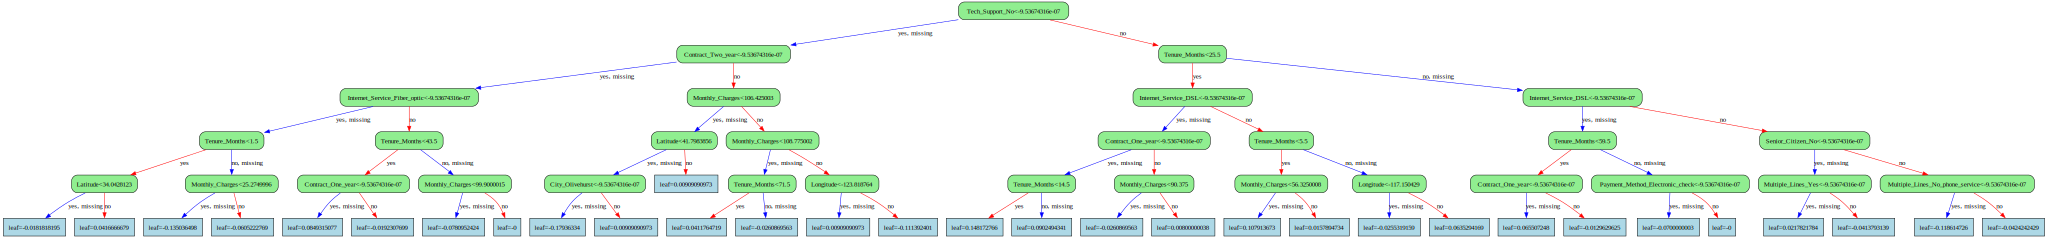

In [31]:
# Printing the XGB Tree

graph_xgb_model=xgb.XGBClassifier(objective='binary:logistic', 
                                        gamma=0.25, 
                                        learning_rate=0.1, 
                                        max_depth=5, 
                                        n_estimators=1, # This needs to be one else will average over boosting round
                                        reg_lambda=10, 
                                        scale_pos_weight=3,
                                        missing=0, 
                                        seed=42,
                                        subsample=0.9,
                                        colsample_bytree=0.5
                                        )

graph_xgb_model.fit(X_Train, y_Train)

nodeparams = {'shape':'box',
              'style':'filled, rounded',
              'fillcolor':'lightgreen'}

leafparams = {'shape':'box',
              'style':'filled',
              'fillcolor':'lightblue'}


graph=xgb.to_graphviz(graph_xgb_model, num_trees=0, size='10,10' , condition_node_params=nodeparams, leaf_node_params=leafparams)
graph